# Proof of concept Pipeline: Subpopulation B, Engineering and Business

In [1]:
import os
import numpy as np 
import pandas as pd 
from copy import deepcopy
import pprint
from collections import defaultdict
from catboost import CatBoostRegressor, CatBoostClassifier
import pickle 

In [2]:
from causal_eval.causal_inference_algorithms import baseline_estimation_all_seeds, dataset_checks, baseline_estimation_one_seed
from causal_eval.ml_utils import COUNTVECTORIZER,predict_y_from_X_crossfit
from causal_eval.utils import *
from causal_eval.sampling import *

import seaborn as sns
import matplotlib.pyplot as plt


Load data

In [3]:
fname = '../data/subpopB_engineering_business.csv'
data = pd.read_csv(fname)

In [4]:
data.head()

,X,Y,T,C
0,Design and Prototyping a New Add-on Module to ...,0,1,1
1,Analytical Inverse Kinematics for a 5-DoF Robo...,0,0,1
2,A Novel Quantum-Dot Cellular Automata X-bit × ...,0,0,0
3,Control of Legged Locomotion Robots\nAbstract ...,0,1,1
4,Experimental investigation of a varactor loade...,0,0,1


In [5]:
rct_stats = dataset_checks(data)

==== DATASET CHECKS ====
Num observations= 2238
Num duplicate papers =  204 (9.12%)
C=1, C=0 balance= 0.5491510277033065
Odds ratio (Y, C)= 1.400636976673843
RCT_ATE =  0.07527175541413487
Mean Y =  0.058534405719392314
T=1%  0.5107238605898123


In [6]:
# Print out for Data Table 
ss = fname.split('/')[-1].rstrip('csv').split('_')
cat1 = ss[1].rstrip('.')
cat2 = ss[2].rstrip('.')
cat1, cat2

('engineering', 'business')

In [7]:
# Prepare X vector
print(COUNTVECTORIZER)
vec = deepcopy(COUNTVECTORIZER)
texts = data['X'].to_numpy()
X = vec.fit_transform(texts).toarray()
print('Vocab length =', len(vec.get_feature_names_out()))

CountVectorizer(binary=True, max_df=0.9, max_features=2000, min_df=5,
                preprocessor=<function preprocess_text at 0x16a728dc0>,
                stop_words='english', strip_accents='unicode')
Vocab length = 2000


Accuracy of P(C|X)

In [8]:
C = data['C'].to_numpy().astype(int)

In [9]:
scores, C_predictions = predict_y_from_X_crossfit(X,
    C,
    y_learning_task="binary",
    n_crossfit=4,
    n_innercv=4,
    n_jobs=10,
    random_state=0)
scores

{'f1': 0.9176470588235295,
 'acc': 0.9092940125111707,
 'mean_hard_pred': 0.5522788203753352,
 'mean_true': 0.5491510277033065,
 'roc_auc': 0.9687144422734043,
 'ave_prec': 0.9746797011059104,
 'calibration_rmse': 0.031053657599428748,
 'mean_soft_pred': 0.5457637085502463}

Diagnostic plots for selecting parameterization of P(T|C)

saved to::  imgs/physics-medicine-diagnostics.png


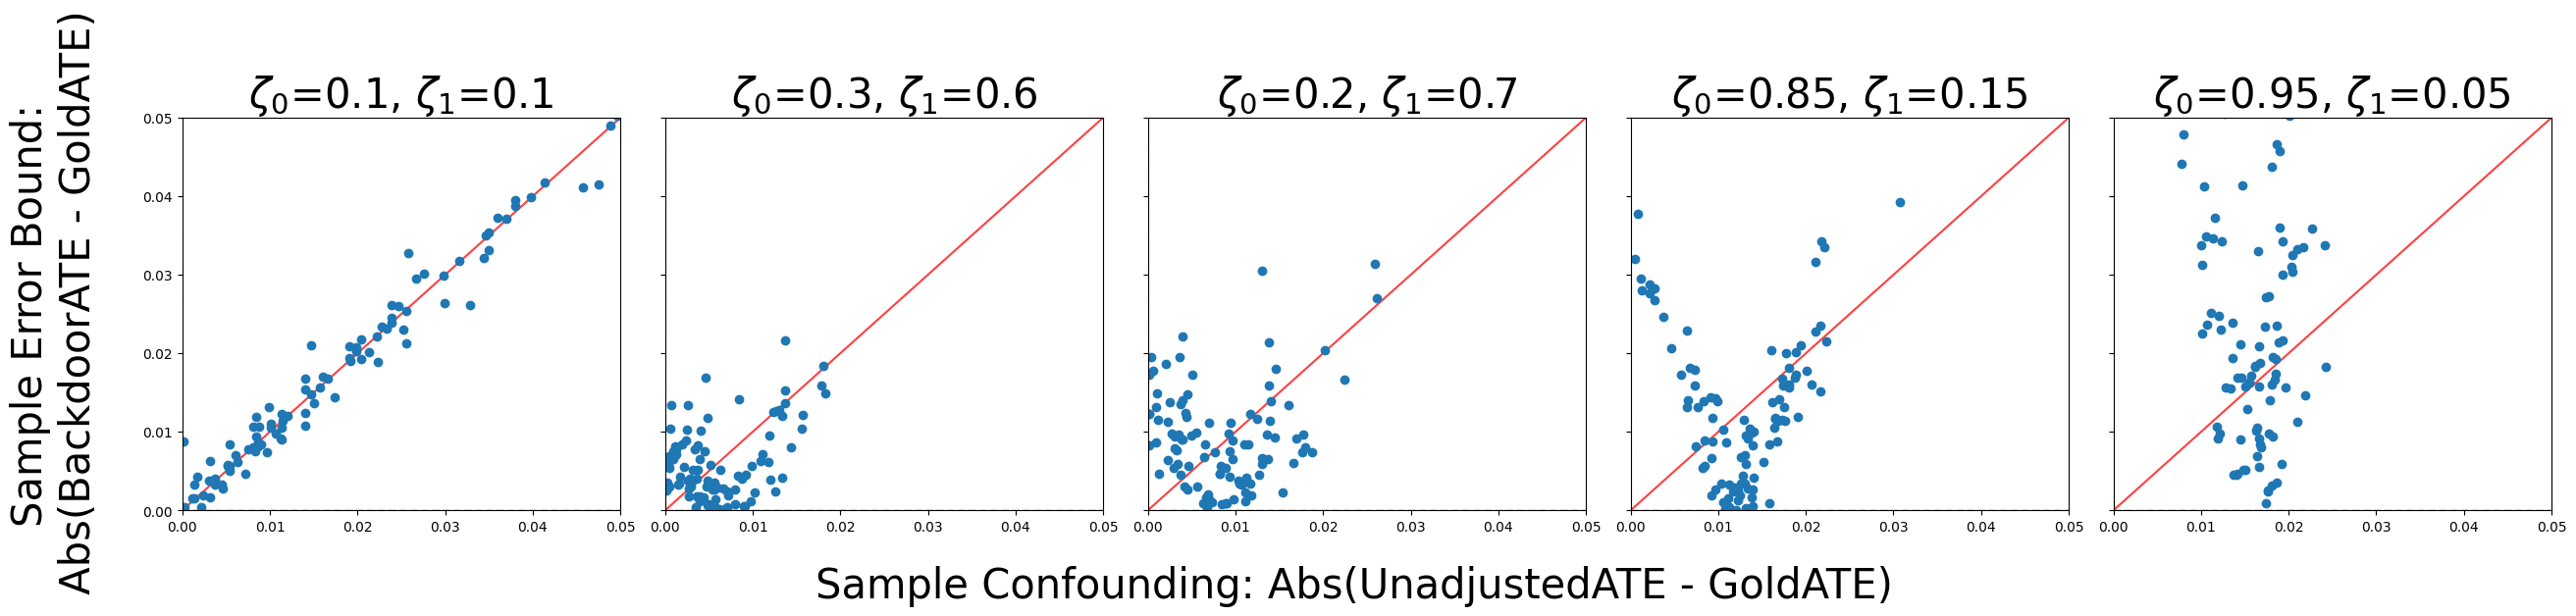

In [10]:
##### SET MANUALLY ########
num_seeds_one_setting = 100 
zeta0_zeta1_list = [(.1, .1), (0.3, 0.6), (0.2, 0.7),(0.85, 0.15), (0.95, 0.05)]
########################### 
#will save to imgs folder
if not os.path.exists('imgs/'): os.mkdir('imgs/')

fig = diagnostic_plot(data, zeta0_zeta1_list, 'imgs/physics-medicine-diagnostics.png', num_seeds_one_setting = num_seeds_one_setting)

Select a parameterization of P(T|C) for the remainder of the estimation pipeline. Here we'll choose $\zeta_0=0.85$, $\zeta_1=0.15$

In [11]:
##### SET MANUALLY ########
num_seeds_one_setting = 100 
zeta0, zeta1 = 0.85, 0.15
########################### 

In [12]:
x, y, data_resampled_all_seeds = one_hyperparam_setting(data, zeta0, zeta1, num_seeds_one_setting)
data_resampled_dict_all_seeds = resampled_data_cleanup(data_resampled_all_seeds, vec)

Saving the confouding datasets to disk 

In [13]:
# This variable is a list where every element in the list is a dictionary corresponding
# to a single random seed
type(data_resampled_dict_all_seeds)

list

In [14]:
# In each dictionary, keys are causal variables (as strings) 
# and values are numpy arrays or sparse matrices
data_resampled_dict_all_seeds[0]

{'Y': array([0, 0, 1, ..., 0, 0, 0]),
 'T': array([0, 0, 1, ..., 0, 1, 1]),
 'C': array([1, 1, 0, ..., 1, 0, 0]),
 'X': <1276x2000 sparse matrix of type '<class 'numpy.int64'>'
 	with 67812 stored elements in Compressed Sparse Row format>}

In [15]:
with open("../data/confounded/subpopB.pkl", "wb") as f:
    pickle.dump(data_resampled_dict_all_seeds, f)

In [16]:
# To read in this data, uncomment and use the following lines

# filename = "../data/confounded/subpopB.pkl"
# with open(filename, "rb") as f:
#     data = pickle.load(f)

Estimation pipeline

In [17]:
# Create a training folder for catboost 
if not os.path.exists('catboost_train/'): os.mkdir('catboost_train/')

In [18]:
# set estimation configs here
expname2config = {} 

#some configs that never change
est_config_base = {
        "n_crossfit": 2,
        "n_repeats": 1,
        "n_jobs_obs_samp": 10,
        "est_g_func": "BOW",
        "y_model": None,  # leave at default
        "t_model": None,  # leave at default
        "y_model_grid": None,
        "t_model_grid": None,
        "propensity_score_cutoff": 0.01, #all models that have propensity score things 
        "n_innercv": 2, #let's keep CV on for now 
        "y_learning_task": "binary" #binary or real-valued
    }

# two settings here: one in which the base model is catboost and the other in which its just logistic/linear regression 
expname2config['no_catboost'] = deepcopy(est_config_base) | {
        "config_id": "2023-07-25-no_catboost",
        "use_catboost": False
    }

expname2config['catboost'] = deepcopy(est_config_base) | {
        "config_id": "2023-07-25-catboost",
        "use_catboost": True, 
        "y_model": CatBoostClassifier(thread_count=1, verbose=False, train_dir='catboost_train/'), 
        "t_model": CatBoostClassifier(thread_count=1, verbose=False, train_dir='catboost_train/')
    }

In [19]:
# Development: make sure just a single estimation runs first 
baseline_estimation_one_seed(data_resampled_dict_all_seeds[0], expname2config['catboost'], n_jobs=10)

{'results': {'outcome_regression_ate': 0.044819327780697395,
  'outcome_regression_ate_ci': (0.04061462598910695, 0.04902402957228784),
  'IPTW_ate': 0.06694115920060122,
  'IPTW_ate_ci': (0.03210418589016059, 0.10177813251104184),
  'AIPTW_ate': 0.06813615621624639,
  'AIPTW_ate_ci': (0.03453122395851298, 0.1017410884739798),
  'double_ml_ate': 0.06355351910383188,
  'double_ml_ate_ci': (0.0627671728386351, 0.06433986536902865),
  'naive_ate': 0.061357789458856324,
  'backdoor_c_ate': 0.06697100201472782},
 'train_pred_model_report_out': {'treatment_model---f1': 0.9579399141630902,
  'treatment_model---acc': 0.9615987460815048,
  'treatment_model---mean_hard_pred': 0.45141065830721006,
  'treatment_model---mean_true': 0.4615987460815047,
  'treatment_model---roc_auc': 0.9916790850206232,
  'treatment_model---ave_prec': 0.990157805970005,
  'treatment_model---calibration_rmse': 0.2242869043571095,
  'treatment_model---mean_soft_pred': 0.4616035492590322,
  'y_model_Tlearner_T=0---f1': 

In [20]:
# supress convergence warnings (comment out if you want these)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [21]:
# All estimations (takes about 70 mins to run)
expname2results = {}
for expname, est_methods_config in expname2config.items():
    expname2results[expname] = baseline_estimation_all_seeds(data_resampled_dict_all_seeds, est_methods_config)

fitting estimation models


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 23.5min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 45.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


fitting estimation models


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 13.2min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 23.1min finished


Printouts for Latex Table 

In [22]:
# Prediction printouts

In [23]:
#### SET MANUALLY ##############
expname = 'no_catboost'
expname_for_print = 'linear' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_predictive_one_experiment(expname, expname_for_print, desired_pred_metric, expname2results, num_seeds_one_setting)

PREDICTIVE MODELS
METRIC = ave_prec
 & treatment_model &  & y_model_Tlearner_T=0 &  & y_model_Tlearner_T=1 &  & y_model_both & 
 & train & inf & train & inf & train & inf & train & inf

linear& 0.99 (0.01) \cellcolor {yellow!99.0}& 0.74 (0.02) \cellcolor {green!74.0}& 0.62 (0.24) \cellcolor {yellow!62.0}& 0.04 (0.01) \cellcolor {green!4.0}& 0.72 (0.23) \cellcolor {yellow!72.0}& 0.13 (0.04) \cellcolor {green!13.0}& 0.67 (0.19) \cellcolor {yellow!67.0}& 0.08 (0.02) \cellcolor {green!8.0}


In [24]:
#### SET MANUALLY ##############
expname = 'catboost'
expname_for_print = 'catboost (nonlinear)' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_predictive_one_experiment(expname, expname_for_print, desired_pred_metric, expname2results, num_seeds_one_setting)

PREDICTIVE MODELS
METRIC = ave_prec
 & treatment_model &  & y_model_Tlearner_T=0 &  & y_model_Tlearner_T=1 &  & y_model_both & 
 & train & inf & train & inf & train & inf & train & inf

catboost (nonlinear)& 0.99 (0.0) \cellcolor {yellow!99.0}& 0.75 (0.02) \cellcolor {green!75.0}& 0.99 (0.01) \cellcolor {yellow!99.0}& 0.04 (0.01) \cellcolor {green!4.0}& 1.0 (0.0) \cellcolor {yellow!100}& 0.14 (0.04) \cellcolor {green!14.0}& 0.99 (0.0) \cellcolor {yellow!99.0}& 0.08 (0.02) \cellcolor {green!8.0}


In [25]:
# Causal estimation printouts 

In [26]:
# Ground truth RCT ACE 
rct_ace =  parametric_backdoor(data, "Y", "T", [])
print("RCT ACE unadjusted", rct_ace)
print("RCT ACE adjusting for C", parametric_backdoor(data, "Y", "T", ["C", "T*C"])) # perform some sanity checks
                                                                                    # in the RCT data we should see unadjusted == adjusted 

RCT ACE unadjusted 0.07527175541413622
RCT ACE adjusting for C 0.07502382400898668


In [27]:
#### SET MANUALLY ##############
expname = 'no_catboost'
expname_for_print = 'linear' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_estimation_one_experiment(expname, expname_for_print, expname2results, num_seeds_one_setting, rct_ace)

CAUSAL ESTIMATION: RELATIVE ABSOLUTE ERROR
& naive& backdoor_c& outcome_regression& IPTW& AIPTW& double_ml

linear& 0.17 (0.08)& 0.18 (0.13)& 1.49 (1.09)\cellcolor {red!100}& 0.79 (0.97)\cellcolor {red!79.0}& 1.79 (2.42)\cellcolor {red!100}& 0.29 (0.21)\cellcolor {red!29.0}


In [28]:
#### SET MANUALLY ##############
expname = 'catboost'
expname_for_print = 'catboost (nonlinear)' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_estimation_one_experiment(expname, expname_for_print, expname2results, num_seeds_one_setting, rct_ace)

CAUSAL ESTIMATION: RELATIVE ABSOLUTE ERROR
& naive& backdoor_c& outcome_regression& IPTW& AIPTW& double_ml

catboost (nonlinear)& 0.17 (0.08)& 0.18 (0.13)& 0.28 (0.1)\cellcolor {red!28.0}& 0.17 (0.12)\cellcolor {red!17.0}& 0.16 (0.12)\cellcolor {red!16.0}& 0.13 (0.09)\cellcolor {red!13.0}


In [29]:
# Table caption printout
table_caption = f"""
Results on an RCT for which we have chosen two structured (low-dimensional) confounders that are 
categories of articles: {cat1} and {cat2}.
For this RCT, n={rct_stats['num_observations']}, 
the RCT ATE is {np.round(rct_stats['rct_ate'], 3)}
and the odds ratio
between the two binary categories and Y is {np.round(rct_stats['odds_ratio'], 2)}. 
For sampling to create a confounded dataset, we choose $\zeta_0=$ {zeta0} and $\zeta_1=$ {zeta1}. 
"""
print(table_caption)


Results on an RCT for which we have chosen two structured (low-dimensional) confounders that are 
categories of articles: engineering and business.
For this RCT, n=2238, 
the RCT ATE is 0.075
and the odds ratio
between the two binary categories and Y is 1.4. 
For sampling to create a confounded dataset, we choose $\zeta_0=$ 0.85 and $\zeta_1=$ 0.15. 

